# Identifying Duplicate Questions

Welcome to the Quora Question Pairs competition! Here, our goal is to identify which questions asked on [Quora](https://www.quora.com/), a quasi-forum website with over 100 million visitors a month, are duplicates of questions that have already been asked. This could be useful, for example, to instantly provide answers to questions that have already been answered. We are tasked with predicting whether a pair of questions are duplicates or not, and submitting a binary prediction against the logloss metric.

If you have any questions or want to discuss competitions/hardware/games/anything with other Kagglers, then join the KaggleNoobs Slack channel [here](https://goo.gl/gGWFXe). We also have regular AMAs with top Kagglers there.

**And as always, if this helped you, some upvotes would be very much appreciated - that's where I get my motivation! :D**

Let's dive right into the data!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-notebook')

print('# File sizes')
for f in os.listdir('../input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

# File sizes
test.csv                      314.02MB


Looks like we are simply given two files this time round, one for the training set and one for the test set. They are relatively small compared to other recent competitions, weighing in at less than 400MB total.

It's worth noting that there is a lot more testing data than training data. This could be a sign that some of the test data is dummy data designed to deter hand-labelling, and not included in the calculations, like we recently saw in the [DSTL competition](https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/leaderboard).

Let's open up one of the datasets.

## Training set

In [2]:
df_train = pd.read_csv('../input/train.csv.zip')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We are given a minimal number of data fields here, consisting of:

**`id`:** Looks like a simple rowID    
**`qid{1, 2}`:** The unique ID of each question in the pair    
**`question{1, 2}`:** The actual textual contents of the questions.    
**`is_duplicate`:** The **label** that we are trying to predict - whether the two questions are duplicates of each other.

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780
Maximum number of times a single question is repeated: 157



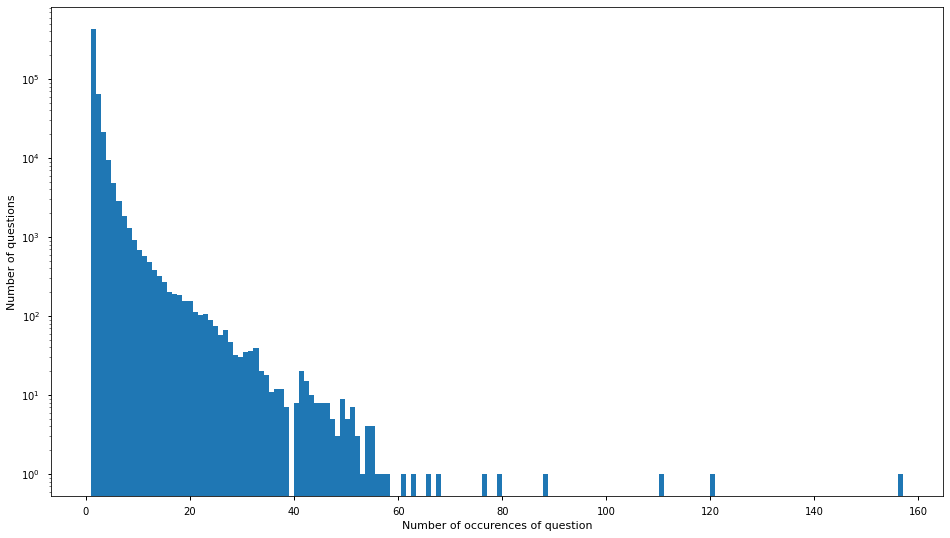

In [3]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(16, 9))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonpositive='clip')
# plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In terms of questions, everything looks as I would expect here. Most questions only appear a few times, with very few questions appearing several times (and a few questions appearing many times). One question appears more than 160 times, but this is an outlier.

We can see that we have a 37% positive class in this dataset. Since we are using the [LogLoss](https://www.kaggle.com/wiki/LogarithmicLoss) metric, and LogLoss looks at the actual predicts as opposed to the order of predictions, we should be able to get a decent score by creating a submission predicting the mean value of the label.

<AxesSubplot:ylabel='id'>

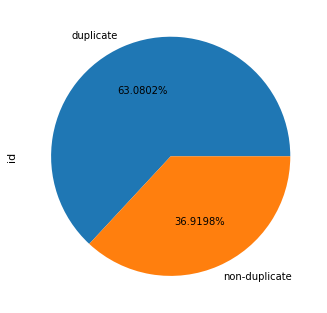

In [4]:
df_train.groupby('is_duplicate')['id'].count().plot.pie(autopct='%1.04f%%', labels={"non-duplicate",'duplicate'})


## Test Submission


**0.55 on the leaderboard! Score!**

However, not all is well. The discrepancy between our local score and the LB one indicates that the distribution of values on the leaderboard is very different to what we have here, which could cause problems with validation later on in the competition.

According to this [excellent notebook by David Thaler](www.kaggle.com/davidthaler/quora-question-pairs/how-many-1-s-are-in-the-public-lb/notebook), using our score and submission we can calculate that we have about 16.5% positives in the test set. This is quite surprising to see, so it'll be something that will need to be taken into account in machine learning models.

Next, I'll take a quick peek at the statistics of the test data before we look at the text itself.

## Test Set

Nothing out of the ordinary here. We are once again given rowIDs and the textual data of the two questions. It is worth noting that we are not given question IDs here however for the two questions in the pair.

It is also worth pointing out that the actual number of test rows are likely to be much lower than 2.3 million. According to the [data page](https://www.kaggle.com/c/quora-question-pairs/data), most of the rows in the test set are using auto-generated questions to pad out the dataset, and deter any hand-labelling. This means that the true number of rows that are scored could be very low.

We can actually see in the head of the test data that some of the questions are obviously auto-generated, as we get delights such as "How their can I start reading?" and "What foods fibre?". Truly insightful questions.

Now onto the good stuff - the text data!
## Text analysis

First off, some quick histograms to understand what we're looking at. **Most analysis here will be only on the training set, to avoid the auto-generated questions**

mean-train 59.82 std-train 31.96 max-train 1169.00


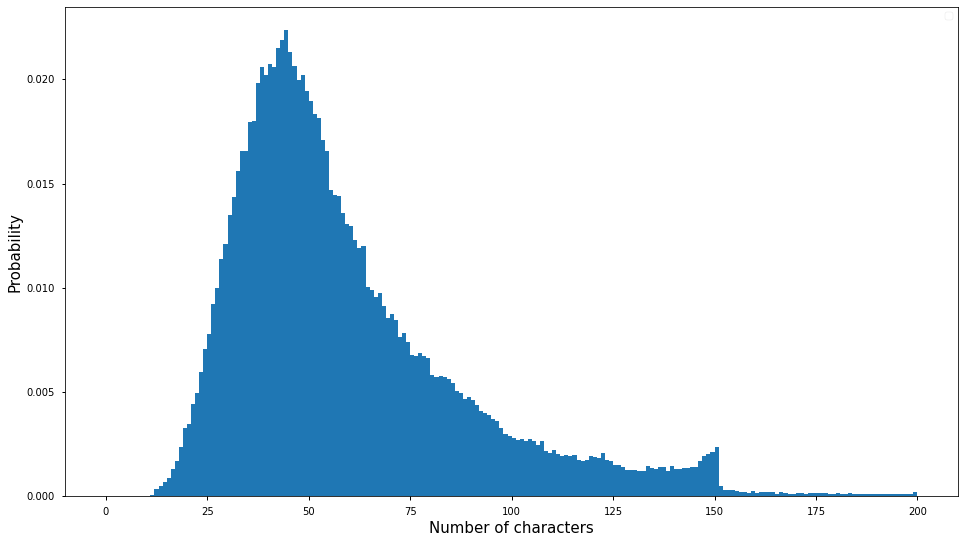

In [5]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
dist_train = train_qs.apply(len)
plt.figure(figsize=(16, 9))
plt.hist(dist_train, bins=200, range=[0, 200], density=True)
# plt.title('Histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} max-train {:.2f}'.format(dist_train.mean(), dist_train.std(), dist_train.max()))

We can see that most questions have anywhere from 15 to 150 characters in them. It seems that the test distribution is a little different from the train one, but not too much so (I can't tell if it is just the larger data reducing noise, but it also seems like the distribution is a lot smoother in the test set).

One thing that catches my eye is the steep cut-off at 150 characters for the training set, for most questions, while the test set slowly decreases after 150. Could this be some sort of Quora question size limit?

It's also worth noting that I've truncated this histogram at 200 characters, and that the max of the distribution is at just under 1200 characters for both sets - although samples with over 200 characters are very rare.

Let's do the same for word count. I'll be using a naive method for splitting words (splitting on spaces instead of using a serious tokenizer), although this should still give us a good idea of the distribution.

mean-train 11.06 std-train 5.89 max-train


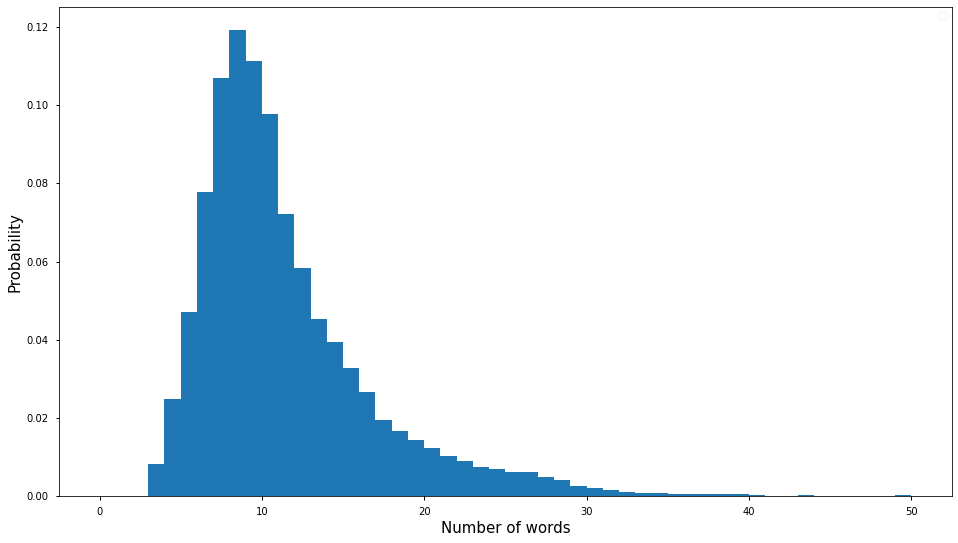

In [6]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
plt.figure(figsize=(16, 9))
plt.hist(dist_train, bins=50, range=[0, 50],density=True)
# plt.title('Histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} max-train'.format(dist_train.mean(), dist_train.std(), dist_train.max()))

We see a similar distribution for word count, with most questions being about 10 words long. It looks to me like the distribution of the training set seems more "pointy", while on the test set it is wider. Nevertheless, they are quite similar.

So what are the most common words? Let's take a look at a word cloud.

## Semantic Analysis

Next, I will take a look at usage of different punctuation in questions - this may form a basis for some interesting features later on.

In [7]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


# Initial Feature Analysis

Before we create a model, we should take a look at how powerful some features are. I will start off with the word share feature from the benchmark model.

Text(0.5, 0, 'word_match_share')

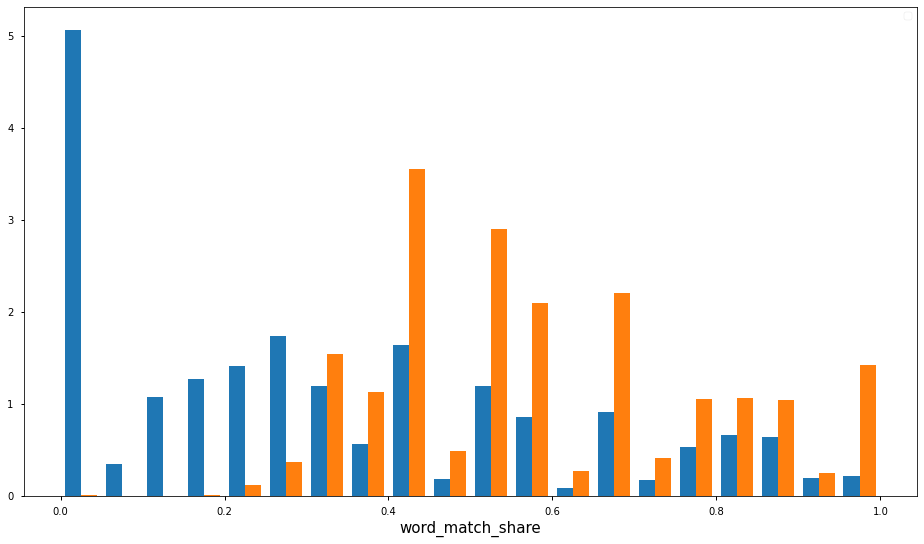

In [8]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(16, 9))
train_word_match = df_train.apply(lambda row: word_match_share(row), axis=1)
plt.hist([train_word_match[df_train['is_duplicate'] == 0], train_word_match[df_train['is_duplicate'] == 1]], bins=20, density=True)
plt.legend()
# plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

using something called TF-IDF (term-frequency-inverse-document-frequency). This means that we weigh the terms by how uncommon they are, meaning that we care more about rare words existing in both questions than common one. This makes sense, as for example we care more about whether the word "exercise" appears in both than the word "and" - as uncommon words will be more indicative of the content.Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

## TF-IDF

I'm now going to try to improve this feature, by using something called TF-IDF (term-frequency-inverse-document-frequency). This means that we weigh the terms by how **uncommon** they are, meaning that we care more about rare words existing in both questions than common one. This makes sense, as for example we care more about whether the word "exercise" appears in both than the word "and" - as uncommon words will be more indicative of the content.

You may want to look into using sklearn's [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute weights if you are implementing this yourself, but as I am too lazy to read the documentation I will write a version in pure python with a few changes which I believe should help the score.

In [9]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [10]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 0, 'word_match_share')

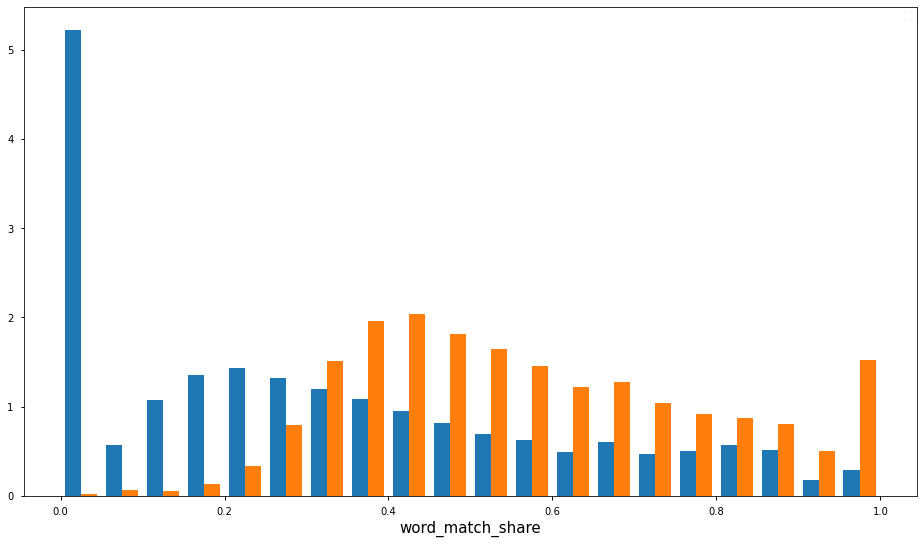

In [11]:
plt.figure(figsize=(16, 9))
tfidf_train_word_match = df_train.apply(lambda row: tfidf_word_match_share(row), axis=1)
plt.hist([tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0)], bins=20, density=True)
plt.legend()
# plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [12]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7804327049353577
   TFIDF AUC: 0.7704802292218704


So it looks like our TF-IDF actually got _worse_ in terms of overall AUC, which is a bit disappointing. (I am using the AUC metric since it is unaffected by scaling and similar, so it is a good metric for testing the predictive power of individual features.

However, I still think that this feature should provide some extra information which is not provided by the original feature. Our next job is to combine these features and use it to make a prediction. For this, I will use our old friend XGBoost to make a classification model.

In [13]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split, KFold

kfold = KFold(n_splits=10)


Evaluate with Recall

In [14]:
from sklearn.metrics import confusion_matrix

accuracy_recalls = []
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)    
    
    A =(((C.T)/(C.sum(axis=1))).T)
    accuracy_recalls.append(A[1][1])
    
    plt.figure(figsize=(11,4))
    
    labels = ['non-duplicate', 'duplicate']
    plt.subplot(1, 2, 1)
    sns.heatmap(C, annot=True, fmt=".0f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Original')
    plt.title("Confusion matrix")
        
    plt.subplot(1, 2, 2)
    sns.heatmap(A, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.title("Recall matrix")
    
    plt.show()   

## XGBoost

Now we can finally run XGBoost on our data, in order to see the score on the leaderboard!

In [15]:
import xgboost as xgb

params = {}
params['gpu_id'] = 0
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4
params['predictor'] = 'gpu_predictor'
params['tree_method'] = 'gpu_hist'

y = df_train['is_duplicate'].fillna(0).values

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68624	test-logloss:0.68621
[100]	train-logloss:0.48104	test-logloss:0.47961
[200]	train-logloss:0.46366	test-logloss:0.46204
[300]	train-logloss:0.46055	test-logloss:0.45925
[399]	train-logloss:0.45911	test-logloss:0.45804


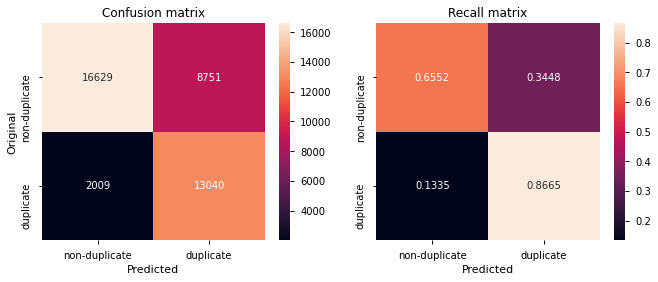

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68623	test-logloss:0.68622
[100]	train-logloss:0.48094	test-logloss:0.48048
[200]	train-logloss:0.46361	test-logloss:0.46304
[300]	train-logloss:0.46057	test-logloss:0.45993
[399]	train-logloss:0.45913	test-logloss:0.45856


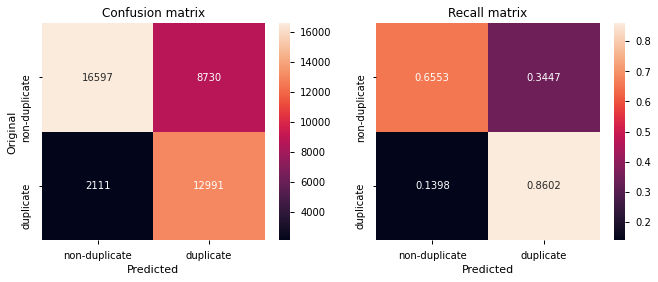

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68622	test-logloss:0.68628
[100]	train-logloss:0.48059	test-logloss:0.48286
[200]	train-logloss:0.46328	test-logloss:0.46590
[300]	train-logloss:0.46025	test-logloss:0.46311
[399]	train-logloss:0.45871	test-logloss:0.46174


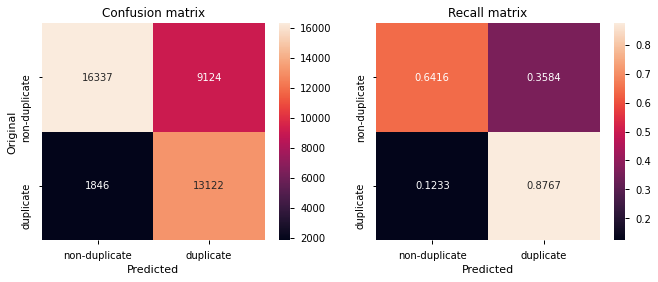

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68623	test-logloss:0.68625
[100]	train-logloss:0.48079	test-logloss:0.48154
[200]	train-logloss:0.46349	test-logloss:0.46418
[300]	train-logloss:0.46049	test-logloss:0.46095
[399]	train-logloss:0.45904	test-logloss:0.45939


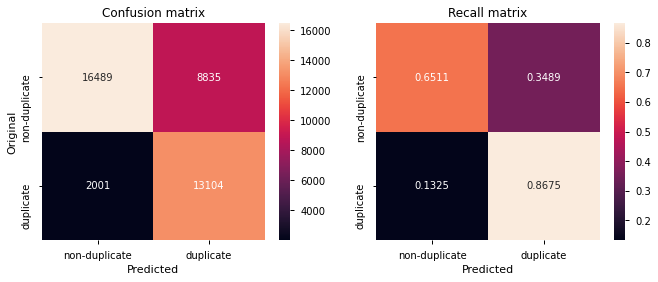

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68622	test-logloss:0.68630
[100]	train-logloss:0.48045	test-logloss:0.48394
[200]	train-logloss:0.46307	test-logloss:0.46744
[300]	train-logloss:0.46005	test-logloss:0.46481
[399]	train-logloss:0.45865	test-logloss:0.46362


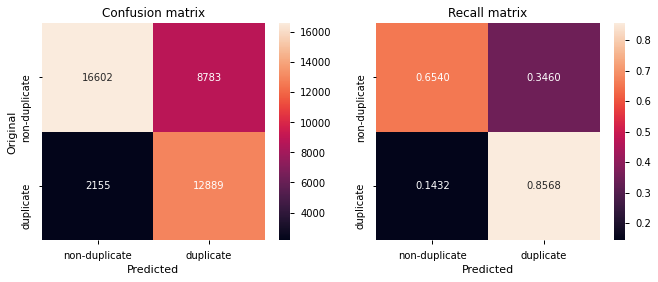

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68622	test-logloss:0.68629
[100]	train-logloss:0.48070	test-logloss:0.48221
[200]	train-logloss:0.46335	test-logloss:0.46511
[300]	train-logloss:0.46031	test-logloss:0.46230
[399]	train-logloss:0.45887	test-logloss:0.46105


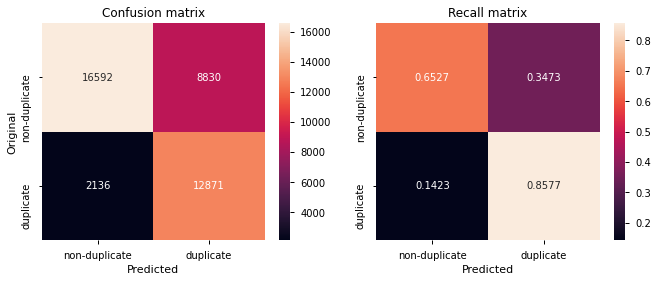

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68623	test-logloss:0.68618
[100]	train-logloss:0.48092	test-logloss:0.47981
[200]	train-logloss:0.46362	test-logloss:0.46248
[300]	train-logloss:0.46063	test-logloss:0.45957
[399]	train-logloss:0.45917	test-logloss:0.45827


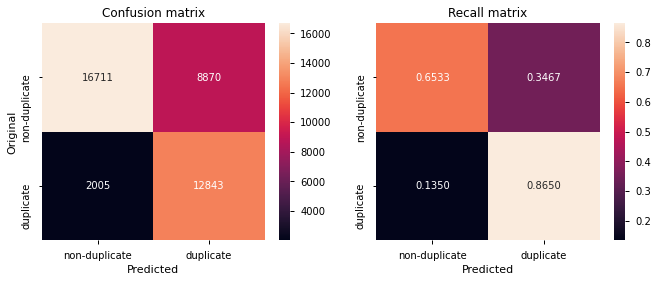

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68623	test-logloss:0.68623
[100]	train-logloss:0.48101	test-logloss:0.47979
[200]	train-logloss:0.46373	test-logloss:0.46200
[300]	train-logloss:0.46065	test-logloss:0.45877
[399]	train-logloss:0.45917	test-logloss:0.45724


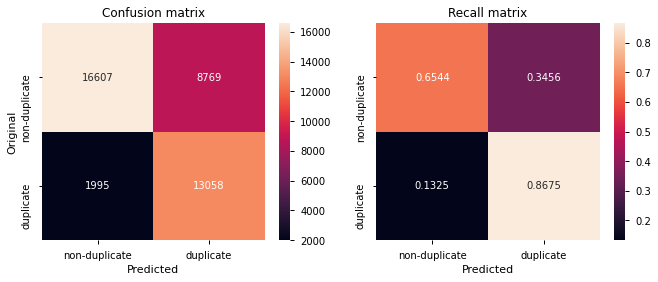

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68622	test-logloss:0.68626
[100]	train-logloss:0.48069	test-logloss:0.48251
[200]	train-logloss:0.46328	test-logloss:0.46567
[300]	train-logloss:0.46023	test-logloss:0.46296
[399]	train-logloss:0.45879	test-logloss:0.46176


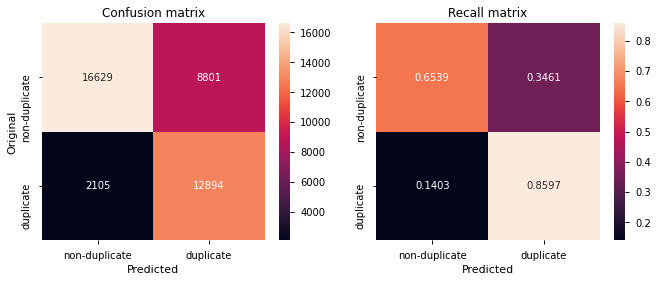

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68624	test-logloss:0.68608
[100]	train-logloss:0.48128	test-logloss:0.47705
[200]	train-logloss:0.46400	test-logloss:0.45948
[300]	train-logloss:0.46098	test-logloss:0.45639
[399]	train-logloss:0.45960	test-logloss:0.45509


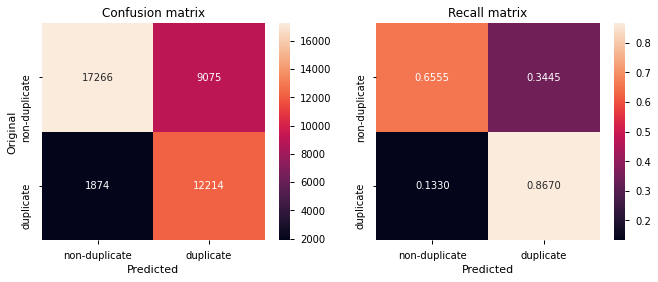

AVG 0.8644


In [16]:
for train_idx, test_idx in kfold.split(train_word_match):
    print(train_idx, test_idx)
    x_train = pd.DataFrame()
    x_test = pd.DataFrame()
    
    x_train['word_match'] = train_word_match[train_idx]
    x_train['tfidf_word_match'] = tfidf_train_word_match[train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test['word_match'] = train_word_match[test_idx]
    x_test['tfidf_word_match'] = tfidf_train_word_match[test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
    
print("AVG {:.4f}".format(np.average(accuracy_recalls)))
accuracy_recalls.clear()

## Words embbedings approach

Using SBERT

In [17]:
!pip install sentence_transformers

     |████████████████████████████████| 81 kB 737 kB/s eta 0:00:01
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.1-py3-none-any.whl size=123336 sha256=264eb8b8ad16f6890a3569050c950f46f9a59df57fb7b7bdeb3221047add0b07
  Stored in directory: /root/.cache/pip/wheels/9d/f2/81/9a97074f4974b3ade9fee286b3ea9acba88e7c9282928ba187
Successfully built sentence-transformers


Cleanning data

In [18]:
def clean_text(text):
    text = str(text).lower().replace(r'[^\x00-\x7f]', r' ')
    for c in [",", "!", ".", "?", '"', ":", ";", "[", "]", "{", "}", "<", ">"]:
        text = text.replace(c, " ")
    tokens = text.split(" ")
    tokens = [word for word in tokens if word not in stops]
    return " ".join(tokens)

clean_text("What's the approx annual cost of living while studying in UIC Chicago, for an Indian student?")

"what's approx annual cost living studying uic chicago  indian student "

Compute similarity of each pair

In [19]:
from sentence_transformers import SentenceTransformer, util

sbert_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

sub_set_size = 32768
cosine_sim = []
total_subset = len(df_train) // sub_set_size # large dataset

for g, sub_df in df_train.groupby(np.arange(len(df_train)) // sub_set_size):
    print("Processing group", g, total_subset)
    question1 = sub_df['question1'].tolist()
    question2 = sub_df['question2'].tolist()
    cleaned_q1 = [clean_text(q) for q in question1]
    cleaned_q2 = [clean_text(q) for q in question2]

    embeddings1 = sbert_model.encode(cleaned_q1, convert_to_tensor=True)
    embeddings2 = sbert_model.encode(cleaned_q2, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    sub_cosine_sim = [cosine_scores[ir][ir].item() for ir in range(len(cleaned_q1))]
    del embeddings1, embeddings2, cleaned_q1, cleaned_q2, question1, question2, cosine_scores

    cosine_sim.extend(sub_cosine_sim)

  0%|          | 0.00/306M [00:00<?, ?B/s]

Processing group 0 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 1 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 2 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 3 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 4 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 5 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 6 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 7 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 8 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 9 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 10 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 11 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing group 12 12


Batches:   0%|          | 0/347 [00:00<?, ?it/s]

Batches:   0%|          | 0/347 [00:00<?, ?it/s]

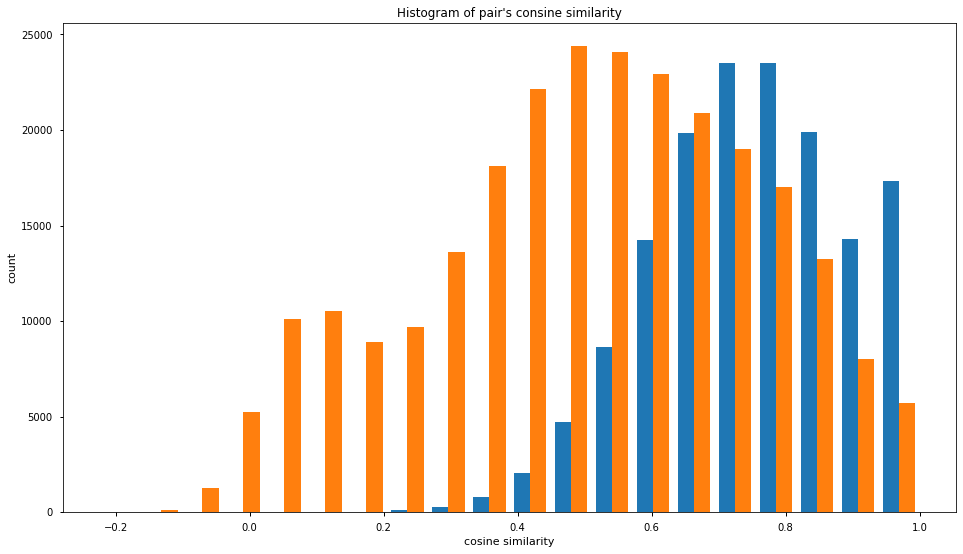

In [20]:
is_duplicated = df_train['is_duplicate'].tolist()

cosine_sim_duplicate = [cosine_sim[idx] for idx,val in enumerate(is_duplicated) if val == 1]
cosine_sim_nonduplicate = [cosine_sim[idx] for idx,val in enumerate(is_duplicated) if val == 0]

plt.figure(figsize=(16, 9))
# plt.yscale('log')
plt.hist([cosine_sim_duplicate, cosine_sim_nonduplicate], bins=20, label=['duplicate', 'non-duplicate'])
plt.title("Histogram of pair's consine similarity")
plt.xlabel('cosine similarity')
plt.ylabel('count')
print()

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68705	test-logloss:0.68708
[100]	train-logloss:0.51433	test-logloss:0.51580
[200]	train-logloss:0.50394	test-logloss:0.50582
[300]	train-logloss:0.50316	test-logloss:0.50513
[395]	train-logloss:0.50308	test-logloss:0.50512


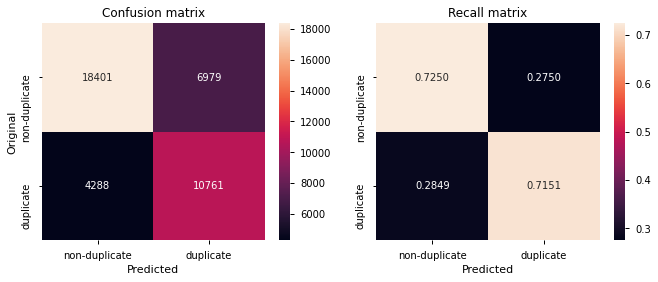

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68706	test-logloss:0.68709
[100]	train-logloss:0.51444	test-logloss:0.51531
[200]	train-logloss:0.50406	test-logloss:0.50489
[300]	train-logloss:0.50328	test-logloss:0.50410
[399]	train-logloss:0.50320	test-logloss:0.50404


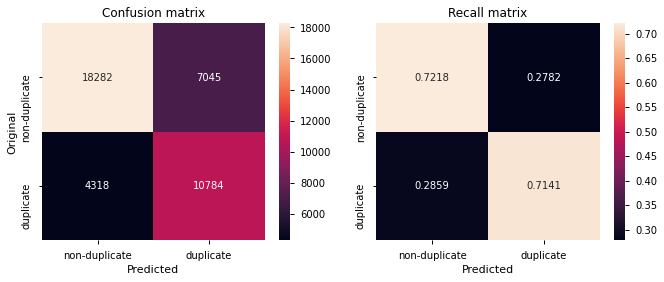

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68706	test-logloss:0.68710
[100]	train-logloss:0.51440	test-logloss:0.51555
[200]	train-logloss:0.50401	test-logloss:0.50522
[300]	train-logloss:0.50323	test-logloss:0.50453
[399]	train-logloss:0.50315	test-logloss:0.50450


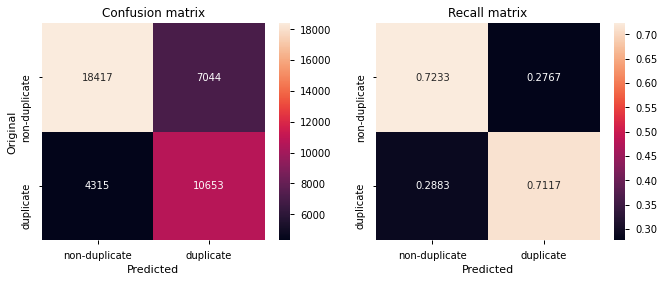

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68705	test-logloss:0.68709
[100]	train-logloss:0.51421	test-logloss:0.51658
[200]	train-logloss:0.50380	test-logloss:0.50699
[300]	train-logloss:0.50302	test-logloss:0.50638
[399]	train-logloss:0.50294	test-logloss:0.50635


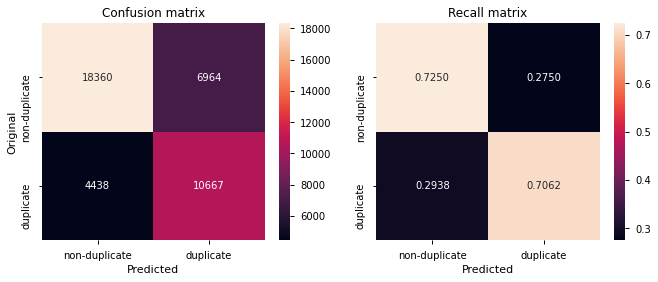

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68704	test-logloss:0.68715
[100]	train-logloss:0.51407	test-logloss:0.51806
[200]	train-logloss:0.50369	test-logloss:0.50809
[300]	train-logloss:0.50290	test-logloss:0.50739
[399]	train-logloss:0.50283	test-logloss:0.50736


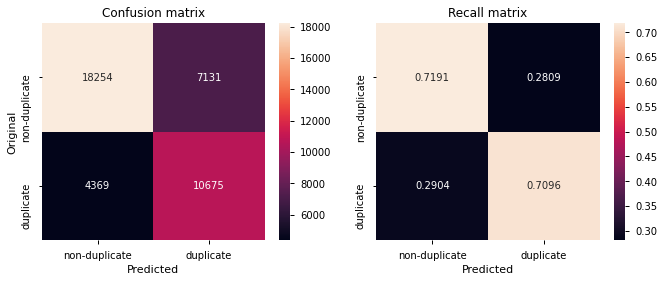

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68705	test-logloss:0.68711
[100]	train-logloss:0.51419	test-logloss:0.51695
[200]	train-logloss:0.50377	test-logloss:0.50733
[300]	train-logloss:0.50298	test-logloss:0.50676
[393]	train-logloss:0.50291	test-logloss:0.50675


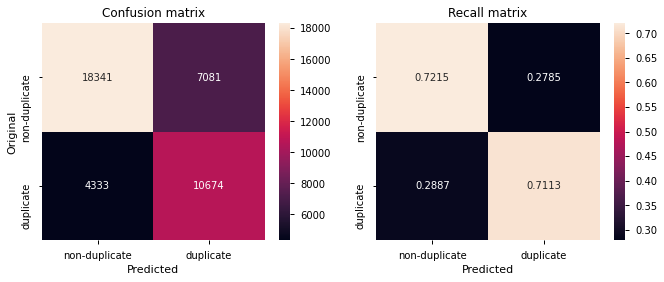

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68707	test-logloss:0.68700
[100]	train-logloss:0.51472	test-logloss:0.51251
[200]	train-logloss:0.50437	test-logloss:0.50193
[300]	train-logloss:0.50359	test-logloss:0.50113
[394]	train-logloss:0.50351	test-logloss:0.50111


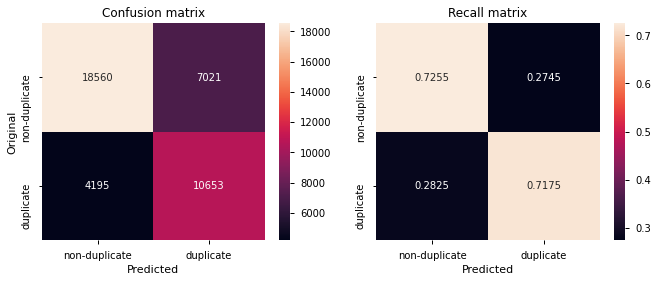

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68707	test-logloss:0.68707
[100]	train-logloss:0.51462	test-logloss:0.51387
[200]	train-logloss:0.50426	test-logloss:0.50321
[300]	train-logloss:0.50348	test-logloss:0.50237
[399]	train-logloss:0.50340	test-logloss:0.50230


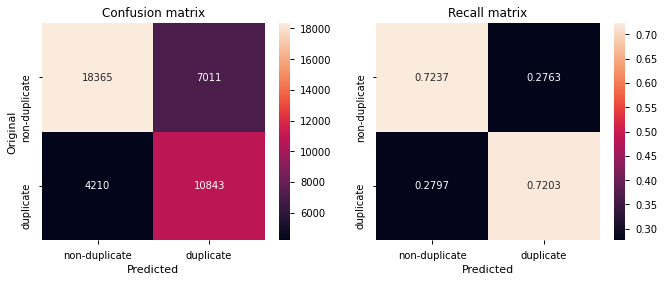

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68706	test-logloss:0.68707
[100]	train-logloss:0.51442	test-logloss:0.51516
[200]	train-logloss:0.50405	test-logloss:0.50500
[300]	train-logloss:0.50327	test-logloss:0.50423
[399]	train-logloss:0.50319	test-logloss:0.50417


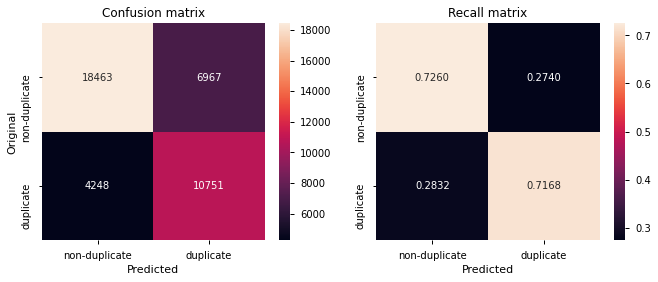

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68709	test-logloss:0.68690
[100]	train-logloss:0.51545	test-logloss:0.50713
[200]	train-logloss:0.50515	test-logloss:0.49528
[300]	train-logloss:0.50438	test-logloss:0.49422
[399]	train-logloss:0.50430	test-logloss:0.49411


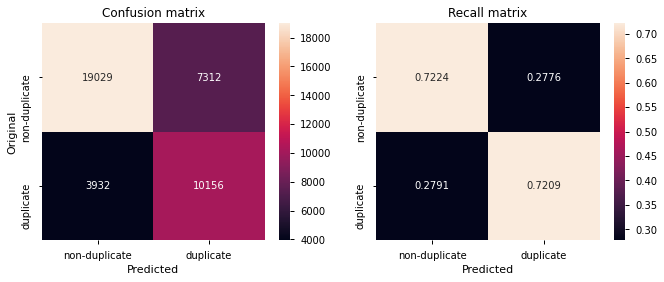

AVG 0.7143


In [21]:
for train_idx, test_idx in kfold.split(cosine_sim):
    print(train_idx, test_idx)
    
    x_train = pd.DataFrame()
    x_train['cosine_sim'] = [cosine_sim[i] for i in train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test = pd.DataFrame()
    x_test['cosine_sim'] = [cosine_sim[i] for i in test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
    
print("AVG {:.4f}".format(np.average(accuracy_recalls)))
accuracy_recalls.clear()

Cross similarity

In [22]:
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder('cross-encoder/quora-distilroberta-base')

sub_set2_size = 32768
total_subset = len(df_train) // sub_set2_size

cross_sim = []
for g, sub_df in df_train.groupby(np.arange(len(df_train)) // sub_set2_size):
    print("Processing cross", g, total_subset)

    sub_cleaned_q1 = [clean_text(q) for q in sub_df['question1']]
    sub_cleaned_q2 = [clean_text(q) for q in sub_df['question2']]
    sentence_combinations = [[q1, q2] for q1,q2 in zip(sub_cleaned_q1, sub_cleaned_q2)]

    cross_scores = cross_encoder.predict(sentence_combinations)
    sub_cross_sim = [cross.item() for cross in cross_scores]
    del sentence_combinations, sub_cleaned_q1, sub_cleaned_q2, cross_scores

    cross_sim.extend(sub_cross_sim)

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/148 [00:00<?, ?B/s]

Processing cross 0 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 1 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 2 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 3 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 4 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 5 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 6 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 7 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 8 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 9 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 10 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 11 12


Batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing cross 12 12


Batches:   0%|          | 0/347 [00:00<?, ?it/s]

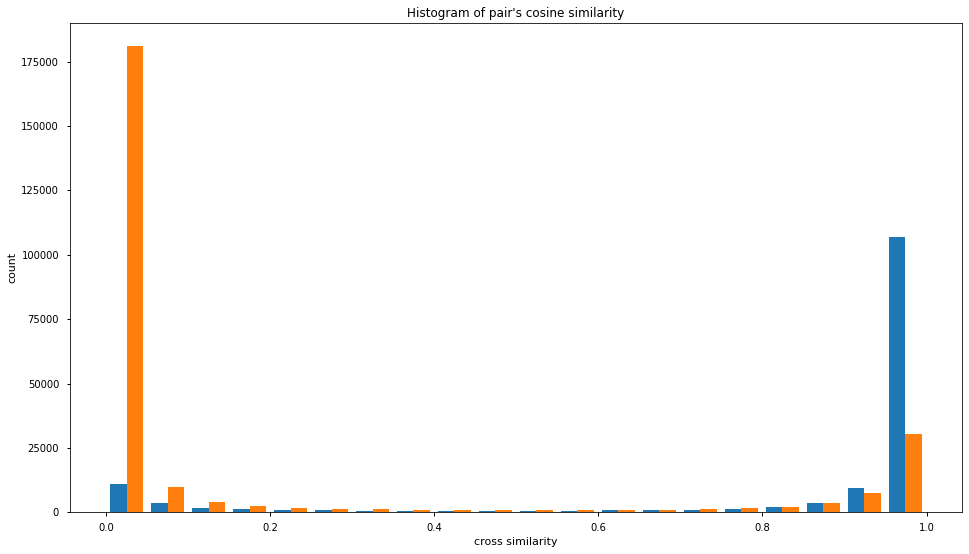

In [23]:
# is_duplicated = df_train['is_duplicate'].tolist()

cross_sim_duplicate = [cross_sim[idx] for idx,val in enumerate(is_duplicated) if val == 1]
cross_sim_nonduplicate = [cross_sim[idx] for idx,val in enumerate(is_duplicated) if val == 0]

plt.figure(figsize=(16, 9))
# plt.yscale('log')
plt.hist([cross_sim_duplicate, cross_sim_nonduplicate], bins=20, label=['duplicate', 'non-duplicate'])
plt.title("Histogram of pair's cosine similarity")
plt.xlabel('cross similarity')
plt.ylabel('count')
print()

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68302	test-logloss:0.68311
[100]	train-logloss:0.39517	test-logloss:0.39900
[200]	train-logloss:0.37785	test-logloss:0.38235
[300]	train-logloss:0.37662	test-logloss:0.38123
[399]	train-logloss:0.37652	test-logloss:0.38116


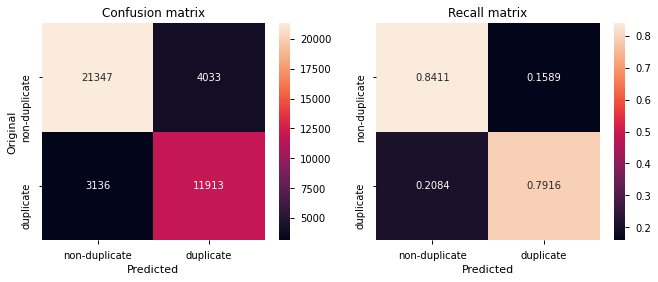

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68304	test-logloss:0.68302
[100]	train-logloss:0.39574	test-logloss:0.39464
[200]	train-logloss:0.37842	test-logloss:0.37738
[300]	train-logloss:0.37717	test-logloss:0.37625
[399]	train-logloss:0.37707	test-logloss:0.37619


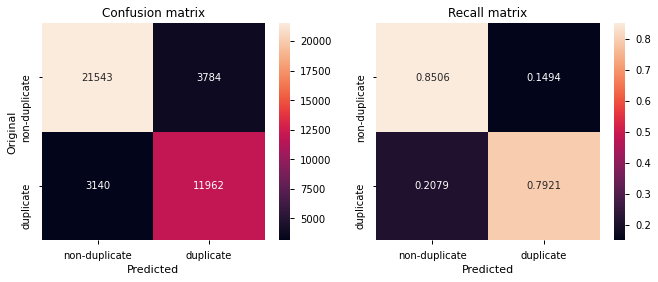

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68304	test-logloss:0.68302
[100]	train-logloss:0.39569	test-logloss:0.39500
[200]	train-logloss:0.37839	test-logloss:0.37756
[300]	train-logloss:0.37715	test-logloss:0.37635
[399]	train-logloss:0.37706	test-logloss:0.37628


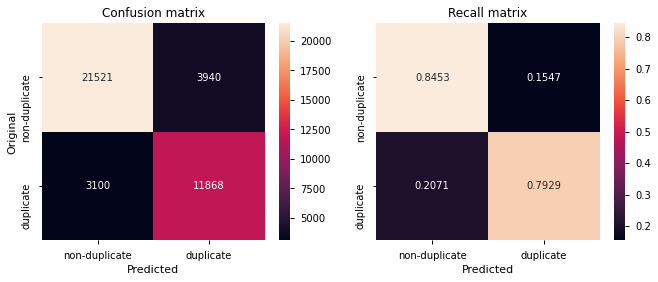

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68304	test-logloss:0.68298
[100]	train-logloss:0.39588	test-logloss:0.39331
[200]	train-logloss:0.37862	test-logloss:0.37562
[300]	train-logloss:0.37739	test-logloss:0.37428
[399]	train-logloss:0.37729	test-logloss:0.37417


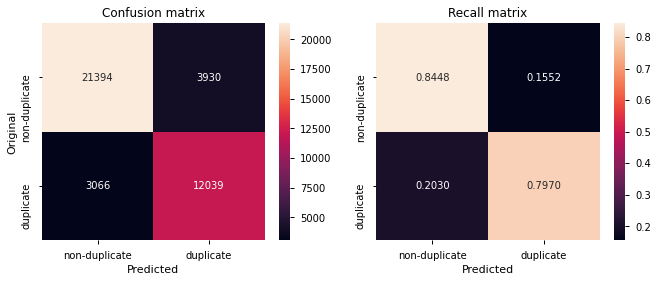

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68303	test-logloss:0.68310
[100]	train-logloss:0.39533	test-logloss:0.39799
[200]	train-logloss:0.37803	test-logloss:0.38091
[300]	train-logloss:0.37679	test-logloss:0.37972
[399]	train-logloss:0.37670	test-logloss:0.37965


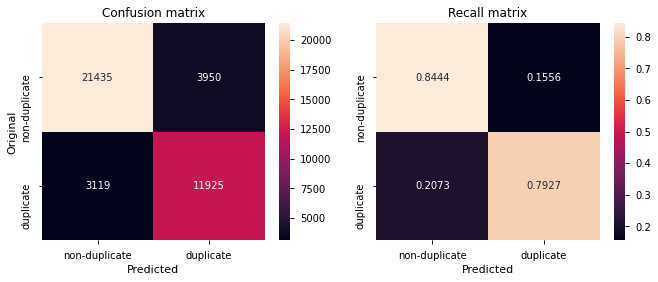

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68302	test-logloss:0.68312
[100]	train-logloss:0.39522	test-logloss:0.39882
[200]	train-logloss:0.37788	test-logloss:0.38214
[300]	train-logloss:0.37664	test-logloss:0.38108
[399]	train-logloss:0.37654	test-logloss:0.38104


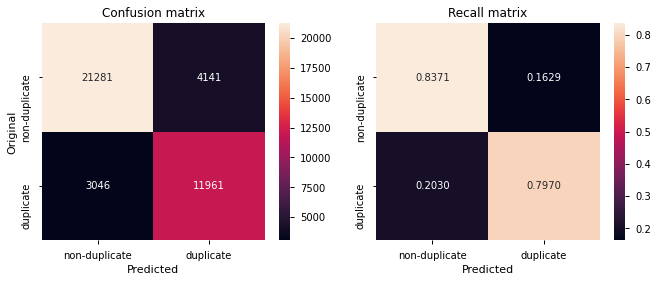

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68304	test-logloss:0.68298
[100]	train-logloss:0.39588	test-logloss:0.39335
[200]	train-logloss:0.37863	test-logloss:0.37550
[300]	train-logloss:0.37741	test-logloss:0.37414
[399]	train-logloss:0.37731	test-logloss:0.37402


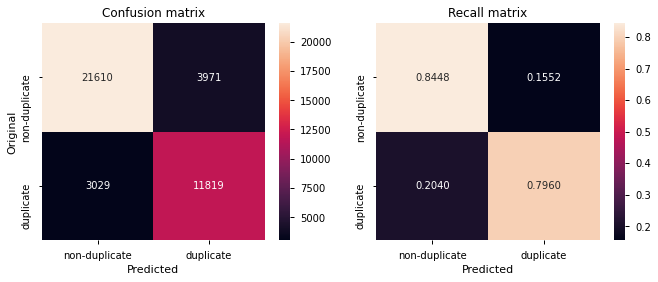

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68304	test-logloss:0.68303
[100]	train-logloss:0.39570	test-logloss:0.39502
[200]	train-logloss:0.37843	test-logloss:0.37742
[300]	train-logloss:0.37720	test-logloss:0.37608
[399]	train-logloss:0.37710	test-logloss:0.37601


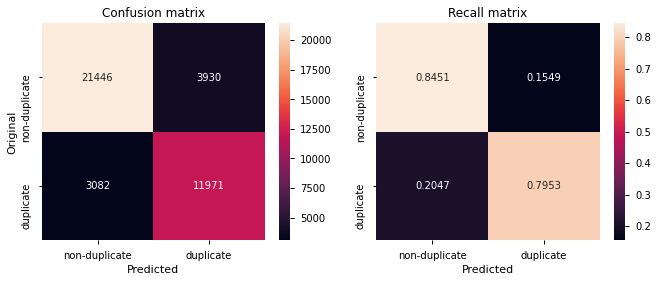

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68303	test-logloss:0.68305
[100]	train-logloss:0.39539	test-logloss:0.39711
[200]	train-logloss:0.37806	test-logloss:0.38051
[300]	train-logloss:0.37682	test-logloss:0.37946
[399]	train-logloss:0.37671	test-logloss:0.37944


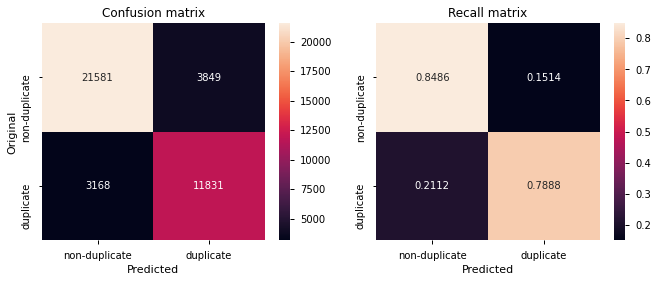

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68304	test-logloss:0.68296
[100]	train-logloss:0.39583	test-logloss:0.39372
[200]	train-logloss:0.37856	test-logloss:0.37629
[300]	train-logloss:0.37732	test-logloss:0.37510
[386]	train-logloss:0.37722	test-logloss:0.37508


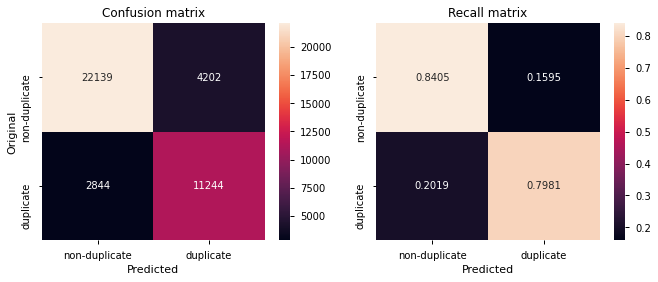

AVG 0.7941


In [24]:
for train_idx, test_idx in kfold.split(cross_sim):
    print(train_idx, test_idx)
    
    x_train = pd.DataFrame()
    x_train['cross_sim'] = [cross_sim[i] for i in train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test = pd.DataFrame()
    x_test['cross_sim'] = [cross_sim[i] for i in test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
    
print("AVG {:.4f}".format(np.average(accuracy_recalls)))
accuracy_recalls.clear()

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68291	test-logloss:0.68300
[100]	train-logloss:0.38908	test-logloss:0.39374
[200]	train-logloss:0.36965	test-logloss:0.37544
[300]	train-logloss:0.36784	test-logloss:0.37400
[399]	train-logloss:0.36748	test-logloss:0.37380


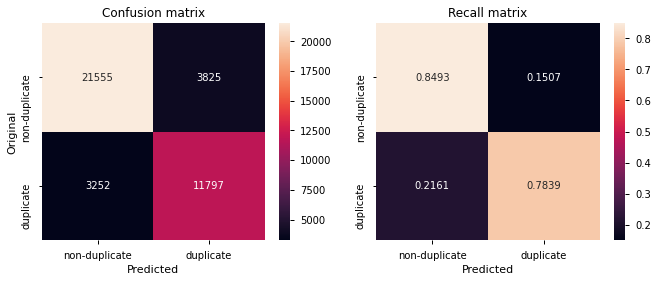

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68293	test-logloss:0.68290
[100]	train-logloss:0.38975	test-logloss:0.38886
[200]	train-logloss:0.37039	test-logloss:0.36957
[300]	train-logloss:0.36859	test-logloss:0.36782
[399]	train-logloss:0.36821	test-logloss:0.36750


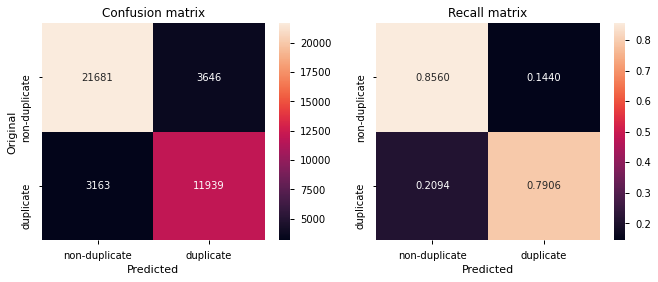

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68293	test-logloss:0.68293
[100]	train-logloss:0.38970	test-logloss:0.38919
[200]	train-logloss:0.37035	test-logloss:0.36968
[300]	train-logloss:0.36855	test-logloss:0.36789
[399]	train-logloss:0.36820	test-logloss:0.36756


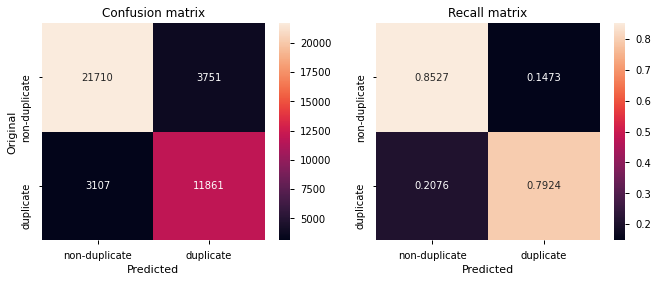

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68293	test-logloss:0.68288
[100]	train-logloss:0.38977	test-logloss:0.38818
[200]	train-logloss:0.37041	test-logloss:0.36883
[300]	train-logloss:0.36860	test-logloss:0.36717
[399]	train-logloss:0.36822	test-logloss:0.36696


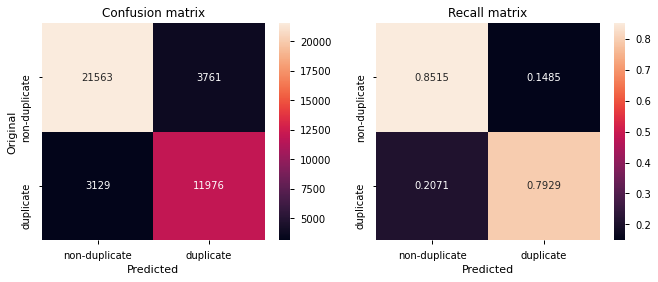

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68291	test-logloss:0.68301
[100]	train-logloss:0.38928	test-logloss:0.39264
[200]	train-logloss:0.36990	test-logloss:0.37359
[300]	train-logloss:0.36810	test-logloss:0.37185
[399]	train-logloss:0.36772	test-logloss:0.37164


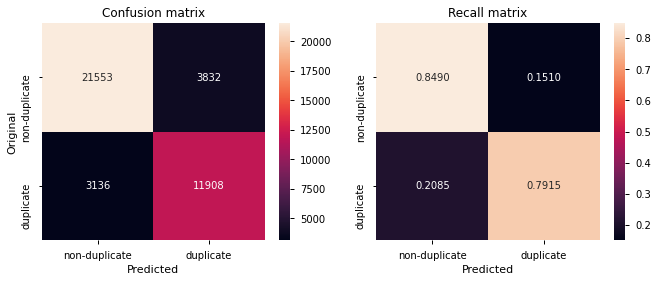

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68292	test-logloss:0.68301
[100]	train-logloss:0.38921	test-logloss:0.39296
[200]	train-logloss:0.36978	test-logloss:0.37447
[300]	train-logloss:0.36797	test-logloss:0.37299
[399]	train-logloss:0.36760	test-logloss:0.37280


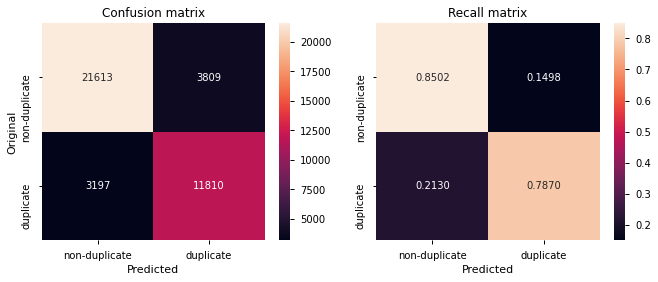

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68293	test-logloss:0.68288
[100]	train-logloss:0.38981	test-logloss:0.38795
[200]	train-logloss:0.37046	test-logloss:0.36828
[300]	train-logloss:0.36869	test-logloss:0.36648
[399]	train-logloss:0.36834	test-logloss:0.36617


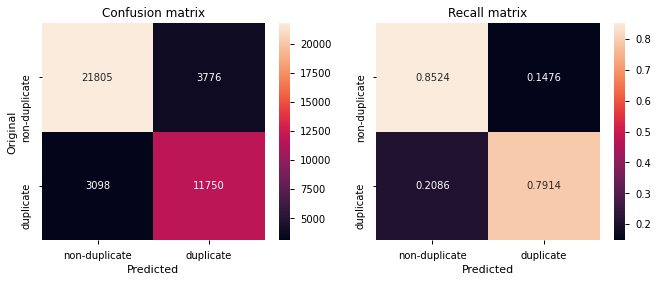

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68293	test-logloss:0.68292
[100]	train-logloss:0.38976	test-logloss:0.38902
[200]	train-logloss:0.37042	test-logloss:0.36926
[300]	train-logloss:0.36863	test-logloss:0.36738
[399]	train-logloss:0.36825	test-logloss:0.36710


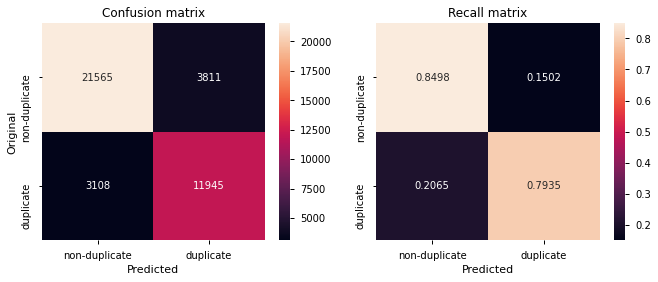

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68293	test-logloss:0.68294
[100]	train-logloss:0.38941	test-logloss:0.39116
[200]	train-logloss:0.36999	test-logloss:0.37254
[300]	train-logloss:0.36819	test-logloss:0.37103
[399]	train-logloss:0.36781	test-logloss:0.37081


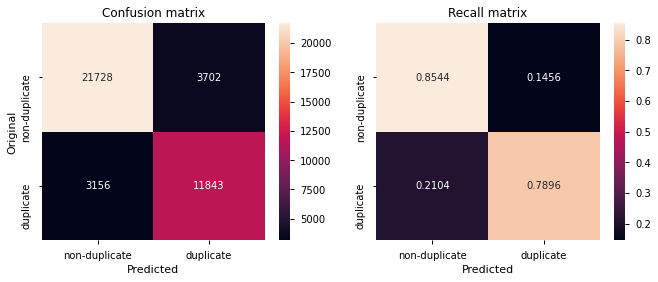

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68294	test-logloss:0.68284
[100]	train-logloss:0.38993	test-logloss:0.38709
[200]	train-logloss:0.37062	test-logloss:0.36732
[300]	train-logloss:0.36881	test-logloss:0.36552
[399]	train-logloss:0.36845	test-logloss:0.36522


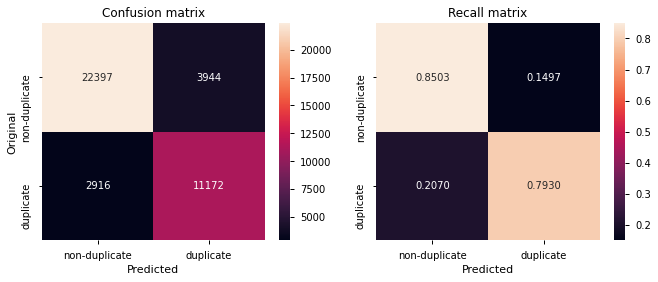

AVG 0.7906


In [25]:
for train_idx, test_idx in kfold.split(cross_sim):
    print(train_idx, test_idx)
    
    x_train = pd.DataFrame()
    x_train['cross_sim'] = [cross_sim[i] for i in train_idx]
    x_train['cosine_sim'] = [cosine_sim[i] for i in train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test = pd.DataFrame()
    x_test['cross_sim'] = [cross_sim[i] for i in test_idx]
    x_test['cosine_sim'] = [cosine_sim[i] for i in test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
    
print("AVG {:.4f}".format(np.average(accuracy_recalls)))
accuracy_recalls.clear()

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68207	test-logloss:0.68213
[100]	train-logloss:0.36141	test-logloss:0.36499
[200]	train-logloss:0.33818	test-logloss:0.34270
[300]	train-logloss:0.33523	test-logloss:0.34007
[399]	train-logloss:0.33433	test-logloss:0.33937


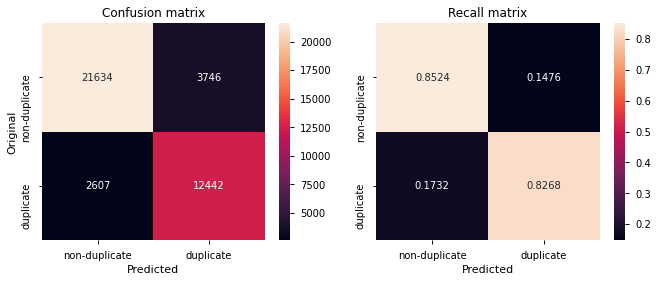

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68209	test-logloss:0.68205
[100]	train-logloss:0.36198	test-logloss:0.36067
[200]	train-logloss:0.33878	test-logloss:0.33736
[300]	train-logloss:0.33584	test-logloss:0.33465
[399]	train-logloss:0.33485	test-logloss:0.33396


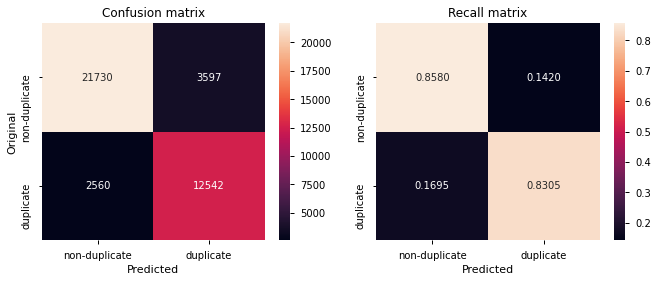

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68208	test-logloss:0.68208
[100]	train-logloss:0.36184	test-logloss:0.36157
[200]	train-logloss:0.33869	test-logloss:0.33836
[300]	train-logloss:0.33575	test-logloss:0.33545
[399]	train-logloss:0.33482	test-logloss:0.33465


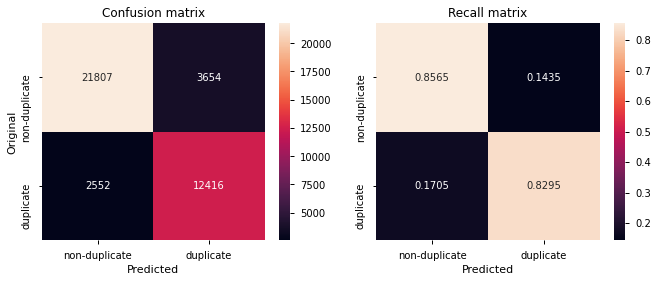

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68208	test-logloss:0.68205
[100]	train-logloss:0.36199	test-logloss:0.36048
[200]	train-logloss:0.33884	test-logloss:0.33688
[300]	train-logloss:0.33595	test-logloss:0.33391
[399]	train-logloss:0.33507	test-logloss:0.33305


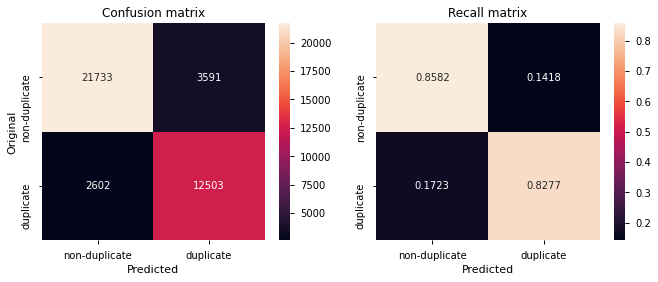

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68206	test-logloss:0.68218
[100]	train-logloss:0.36133	test-logloss:0.36570
[200]	train-logloss:0.33810	test-logloss:0.34329
[300]	train-logloss:0.33516	test-logloss:0.34070
[399]	train-logloss:0.33424	test-logloss:0.34003


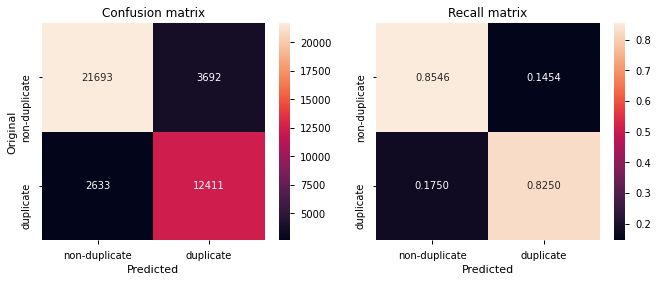

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68207	test-logloss:0.68215
[100]	train-logloss:0.36157	test-logloss:0.36403
[200]	train-logloss:0.33834	test-logloss:0.34128
[300]	train-logloss:0.33542	test-logloss:0.33863
[399]	train-logloss:0.33452	test-logloss:0.33799


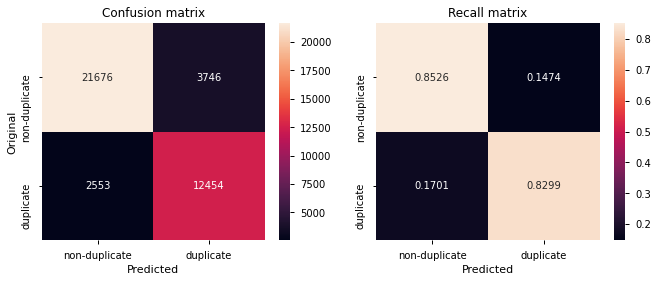

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68209	test-logloss:0.68205
[100]	train-logloss:0.36198	test-logloss:0.36046
[200]	train-logloss:0.33883	test-logloss:0.33693
[300]	train-logloss:0.33596	test-logloss:0.33394
[399]	train-logloss:0.33501	test-logloss:0.33307


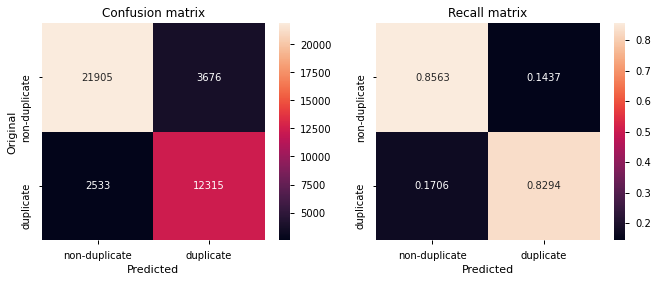

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68209	test-logloss:0.68204
[100]	train-logloss:0.36223	test-logloss:0.35914
[200]	train-logloss:0.33910	test-logloss:0.33509
[300]	train-logloss:0.33620	test-logloss:0.33195
[399]	train-logloss:0.33530	test-logloss:0.33103


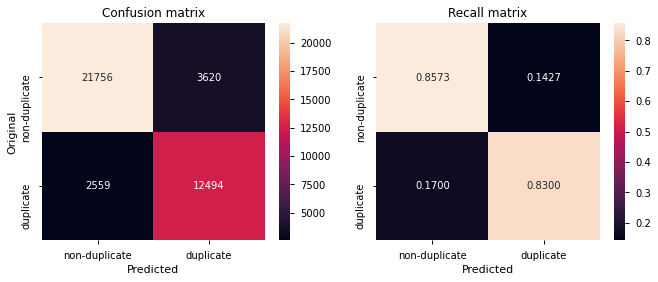

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68207	test-logloss:0.68211
[100]	train-logloss:0.36146	test-logloss:0.36398
[200]	train-logloss:0.33819	test-logloss:0.34216
[300]	train-logloss:0.33527	test-logloss:0.33980
[399]	train-logloss:0.33436	test-logloss:0.33911


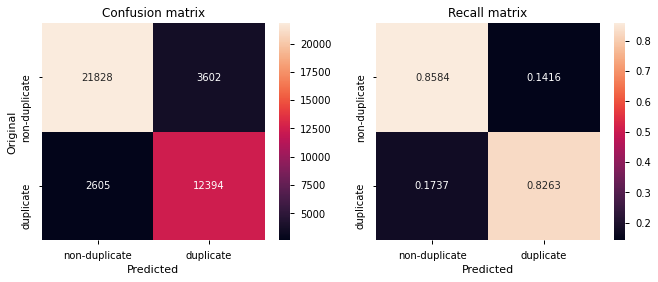

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68209	test-logloss:0.68199
[100]	train-logloss:0.36200	test-logloss:0.35991
[200]	train-logloss:0.33888	test-logloss:0.33665
[300]	train-logloss:0.33600	test-logloss:0.33371
[399]	train-logloss:0.33513	test-logloss:0.33292


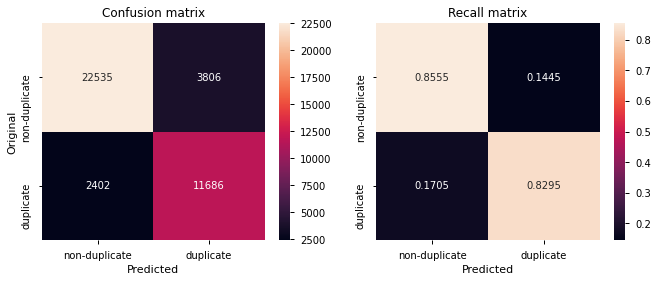

AVG 0.8285


In [26]:
for train_idx, test_idx in kfold.split(cross_sim):
    print(train_idx, test_idx)
    
    x_train = pd.DataFrame()
    x_train['word_match'] = train_word_match[train_idx]
    x_train['tfidf_word_match'] = tfidf_train_word_match[train_idx]
    x_train['cross_sim'] = [cross_sim[i] for i in train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test = pd.DataFrame()
    x_test['word_match'] = train_word_match[test_idx]
    x_test['tfidf_word_match'] = tfidf_train_word_match[test_idx]
    x_test['cross_sim'] = [cross_sim[i] for i in test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
    
print("AVG {:.4f}".format(np.average(accuracy_recalls)))
accuracy_recalls.clear()

Combination of deeplearning approach and NLP approach

[ 40429  40430  40431 ... 404287 404288 404289] [    0     1     2 ... 40426 40427 40428]
[0]	train-logloss:0.68207	test-logloss:0.68213
[100]	train-logloss:0.36138	test-logloss:0.36492
[200]	train-logloss:0.33754	test-logloss:0.34226
[300]	train-logloss:0.33418	test-logloss:0.33936
[399]	train-logloss:0.33278	test-logloss:0.33826


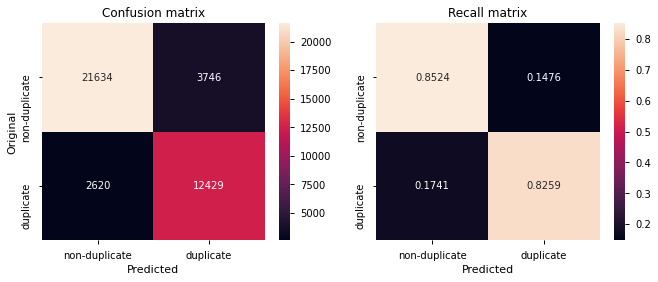

[     0      1      2 ... 404287 404288 404289] [40429 40430 40431 ... 80855 80856 80857]
[0]	train-logloss:0.68209	test-logloss:0.68205
[100]	train-logloss:0.36195	test-logloss:0.36066
[200]	train-logloss:0.33819	test-logloss:0.33684
[300]	train-logloss:0.33473	test-logloss:0.33362
[399]	train-logloss:0.33349	test-logloss:0.33270


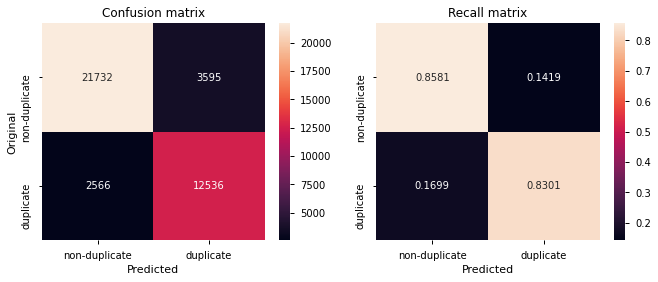

[     0      1      2 ... 404287 404288 404289] [ 80858  80859  80860 ... 121284 121285 121286]
[0]	train-logloss:0.68208	test-logloss:0.68208
[100]	train-logloss:0.36181	test-logloss:0.36153
[200]	train-logloss:0.33815	test-logloss:0.33777
[300]	train-logloss:0.33477	test-logloss:0.33442
[399]	train-logloss:0.33339	test-logloss:0.33325


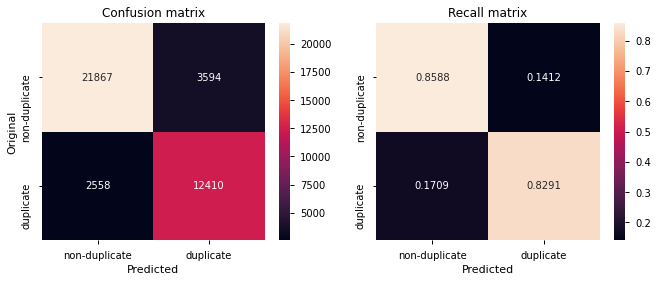

[     0      1      2 ... 404287 404288 404289] [121287 121288 121289 ... 161713 161714 161715]
[0]	train-logloss:0.68208	test-logloss:0.68205
[100]	train-logloss:0.36194	test-logloss:0.36050
[200]	train-logloss:0.33821	test-logloss:0.33661
[300]	train-logloss:0.33484	test-logloss:0.33334
[399]	train-logloss:0.33352	test-logloss:0.33226


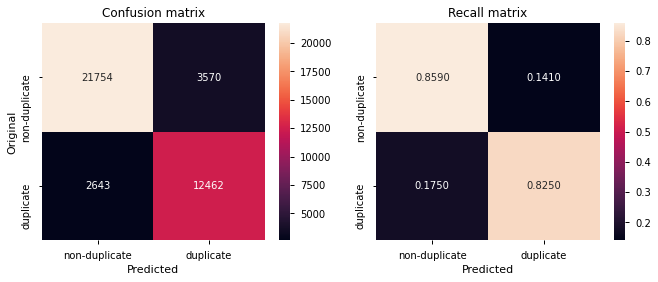

[     0      1      2 ... 404287 404288 404289] [161716 161717 161718 ... 202142 202143 202144]
[0]	train-logloss:0.68206	test-logloss:0.68218
[100]	train-logloss:0.36129	test-logloss:0.36566
[200]	train-logloss:0.33751	test-logloss:0.34277
[300]	train-logloss:0.33406	test-logloss:0.33964
[399]	train-logloss:0.33279	test-logloss:0.33867


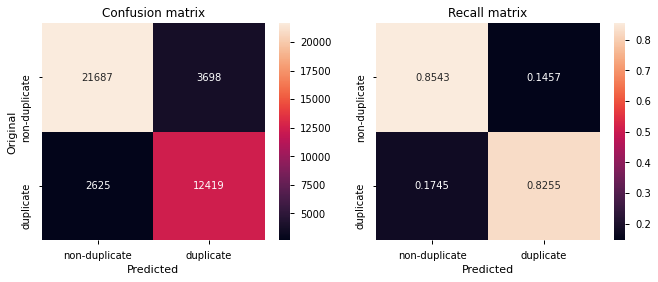

[     0      1      2 ... 404287 404288 404289] [202145 202146 202147 ... 242571 242572 242573]
[0]	train-logloss:0.68207	test-logloss:0.68215
[100]	train-logloss:0.36155	test-logloss:0.36398
[200]	train-logloss:0.33778	test-logloss:0.34073
[300]	train-logloss:0.33437	test-logloss:0.33765
[399]	train-logloss:0.33305	test-logloss:0.33644


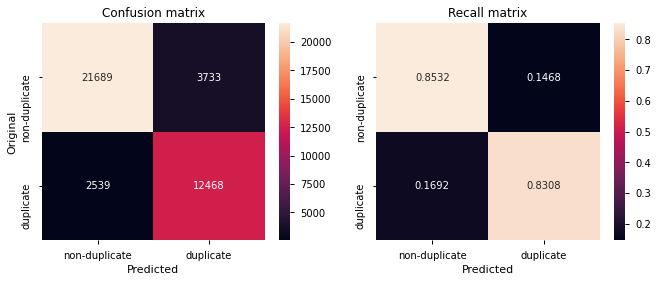

[     0      1      2 ... 404287 404288 404289] [242574 242575 242576 ... 283000 283001 283002]
[0]	train-logloss:0.68209	test-logloss:0.68205
[100]	train-logloss:0.36193	test-logloss:0.36044
[200]	train-logloss:0.33825	test-logloss:0.33647
[300]	train-logloss:0.33488	test-logloss:0.33309
[399]	train-logloss:0.33348	test-logloss:0.33185


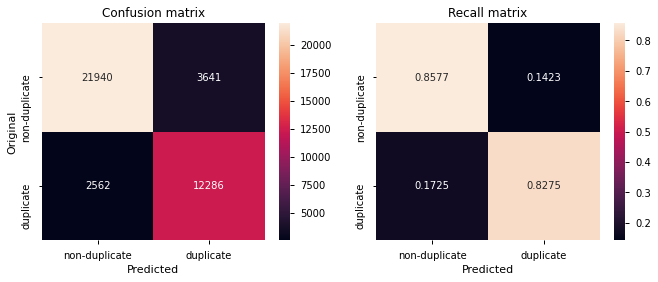

[     0      1      2 ... 404287 404288 404289] [283003 283004 283005 ... 323429 323430 323431]
[0]	train-logloss:0.68209	test-logloss:0.68204
[100]	train-logloss:0.36220	test-logloss:0.35917
[200]	train-logloss:0.33850	test-logloss:0.33471
[300]	train-logloss:0.33511	test-logloss:0.33117
[399]	train-logloss:0.33382	test-logloss:0.32983


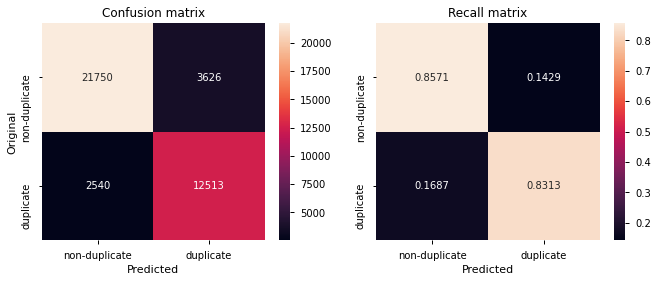

[     0      1      2 ... 404287 404288 404289] [323432 323433 323434 ... 363858 363859 363860]
[0]	train-logloss:0.68207	test-logloss:0.68211
[100]	train-logloss:0.36142	test-logloss:0.36397
[200]	train-logloss:0.33763	test-logloss:0.34163
[300]	train-logloss:0.33419	test-logloss:0.33890
[399]	train-logloss:0.33289	test-logloss:0.33798


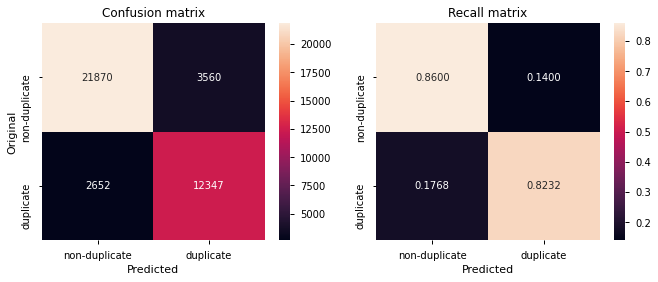

[     0      1      2 ... 363858 363859 363860] [363861 363862 363863 ... 404287 404288 404289]
[0]	train-logloss:0.68209	test-logloss:0.68199
[100]	train-logloss:0.36197	test-logloss:0.35981
[200]	train-logloss:0.33834	test-logloss:0.33599
[300]	train-logloss:0.33498	test-logloss:0.33267
[399]	train-logloss:0.33368	test-logloss:0.33161


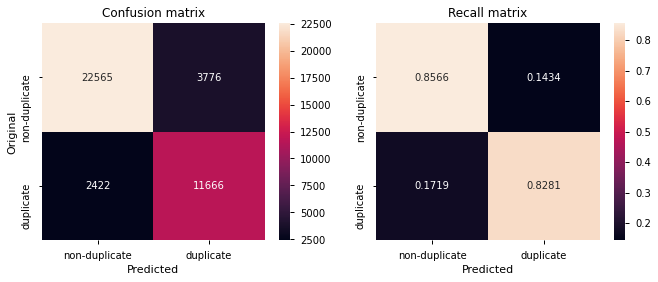

AVG 0.8276


In [27]:
for train_idx, test_idx in kfold.split(train_word_match):
    print(train_idx, test_idx)
    x_train = pd.DataFrame()
    x_test = pd.DataFrame()
    
    x_train['word_match'] = train_word_match[train_idx]
    x_train['tfidf_word_match'] = tfidf_train_word_match[train_idx]
    x_train['cross_sim'] =  [cross_sim[i] for i in train_idx]
    x_train['cosine_sim'] =  [cosine_sim[i] for i in train_idx]
    x_train.fillna(0)
    y_train = y[train_idx]
    d_train = xgb.DMatrix(x_train, label=y_train)
    
    x_test['word_match'] = train_word_match[test_idx]
    x_test['tfidf_word_match'] = tfidf_train_word_match[test_idx]
    x_test['cross_sim'] =  [cross_sim[i] for i in test_idx]
    x_test['cosine_sim'] =  [cosine_sim[i] for i in test_idx]
    x_test.fillna(0)
    y_test = y[test_idx]
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

    y_est = bst.predict(d_test)
    y_pred =np.array(y_est>0.5,dtype=int)
    plot_confusion_matrix(y_test, y_pred)
print("AVG {:.4f}".format(np.average(accuracy_recalls)))
accuracy_recalls.clear()